**KÜTÜPHANE YÜKELME**

In [16]:
# Ortamda CUDA loglarının tekrar tekrar yazılmasını engelleyelim
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'   # 0 = tüm loglar, 1 = INFO'yu kapat, 2 = INFO+WARNING'u kapat, 3 = hepsini kapat

# ==============================
# 📚 Gerekli kütüphaneler
# ==============================
import os
import time
import shutil
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

warnings.filterwarnings('ignore')


# TensorFlow GPU uyumluluk kontrolü
print("TensorFlow sürümü:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU kullanılabilir: {gpus[0].name}")
    try:
        # GPU belleğini kontrollü kullanalım (cuDNN hatalarını azaltır)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("GPU yapılandırma hatası:", e)
else:
    print("GPU kullanılabilir değil, CPU kullanılacak.")


TensorFlow sürümü: 2.18.0
GPU kullanılabilir: /physical_device:GPU:0


**VERİ SETİ YÜKLEME** 

**VERİ SETİ:**

fer2013 veri setindeki veriler, 48x48 piksel gri tonlamalı yüz görüntülerinden oluşmaktadır. Yüzler, her görüntüde yüzün aşağı yukarı ortalanmış ve yaklaşık aynı alanı kaplayacak şekilde otomatik olarak kaydedilmiştir. Amaç yüz ifadesinde gösterilen duyguya göre her yüzü yedi kategoriden birine (0=Öfkeli, 1=İğrenme, 2=Korku, 3=Mutlu, 4=Üzgün, 5=Şaşkın, 6=Nötr) ayırmaktır. Eğitim seti 28.709 örnekten, herkese açık test seti ise 3.589 örnekten oluşmaktadır.

Bu kısımda veri setinin eğitim (train_dir) ve test (test_dir) klasörleri belirtilmiştir.

img_size = 48: veri seti zaten 48x48 piksel gri ölçekli yüz ifadelerinden oluşur. Bu nedenle modelin giriş boyutu veri setiyle uyumlu olacak şekilde seçilmiştir. Daha büyük boyutlar seçilirse ek hesaplama maliyeti çıkar, daha küçük seçilirse bilgi kaybı olur.

batch_size = 32: Eğitim sırasında aynı anda 32 görüntü modele verilir. Bu, belleği verimli kullanmayı ve modelin parametre güncellemelerini dengeli şekilde yapmasını sağlar. Daha küçük batch değerleri eğitim süresini uzatırken, çok büyük değerler belleğe yük bindirebilir.

In [17]:
# ==============================
# 1️⃣ Dataset yolunu ayarla
# ==============================
train_dir = "/kaggle/input/fer2013/train"
test_dir  = "/kaggle/input/fer2013/test" 

img_size = 48
batch_size = 32


**VERİ SETİ ÖN İŞLEME**

Veri seti, model eğitimine uygun hale getirilmek üzere ön işleme adımlarından geçirilmiştir. 

Veri önişleme veri setini tanımak ve anşamlandırmak 
çin yapılan işlemler dizinidir. Veriler çalışma dizinine kopyalanmış ve proje kapsamında kullanılmayan “disgust” sınıfı veri setinden çıkarılmıştır. Eğitim verileri, `ImageDataGenerator` ile normalize edilip yeniden ölçeklendirilmiş, ayrıca zoom, kaydırma ve yatay çevirme gibi veri artırma teknikleriyle çeşitlendirilmiştir; doğrulama için %15’lik bir ayrım yapılmıştır. Test verileri ise yalnızca normalize edilmiştir. Sınıflar arasında denge sağlamak ve bellek kullanımını optimize etmek amacıyla her sınıftan en fazla 4000 görüntü seçilmiş, böylece dengeli bir eğitim kümesi oluşturulmuştur.
Ardından eğitim, doğrulama ve test için ayrı generator nesneleri tanımlanmış ve sınıf dengesizliğini azaltmak üzere `class_weight` hesaplanarak modele eklenmiştir. Bu sayede veri seti, daha dengeli, genelleştirilebilir ve etkili bir model eğitimi için hazır hale getirilmiştir.


In [18]:
import random

source_base = "/kaggle/input/fer2013"
target_base = "/kaggle/working/fer2013"

for subfolder in ["train", "test"]:
    src = os.path.join(source_base, subfolder)
    dst = os.path.join(target_base, subfolder)
    shutil.copytree(src, dst, dirs_exist_ok=True)

def remove_disgust_from_dir(base_dir, disgust_label='disgust'):
    disgust_path = os.path.join(base_dir, disgust_label)
    if os.path.exists(disgust_path):
        shutil.rmtree(disgust_path)
    else:
        print(f"Error")

train_dir = os.path.join(target_base, "train")
test_dir = os.path.join(target_base, "test")

remove_disgust_from_dir(train_dir)
remove_disgust_from_dir(test_dir)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    validation_split=0.15,
    width_shift_range=0.2,
    height_shift_range=0.1,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

def limit_class_images(source_dir, target_dir, max_per_class=4000):
    os.makedirs(target_dir, exist_ok=True)
    class_names = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for cls in class_names:
        src_cls_dir = os.path.join(source_dir, cls)
        dst_cls_dir = os.path.join(target_dir, cls)
        os.makedirs(dst_cls_dir, exist_ok=True)

        imgs = os.listdir(src_cls_dir)
        if len(imgs) > max_per_class:
            imgs = random.sample(imgs, max_per_class)

        for img in imgs:
            shutil.copy2(os.path.join(src_cls_dir, img), os.path.join(dst_cls_dir, img))

limited_train_dir = "/kaggle/working/fer2013_train_limited"
limit_class_images(train_dir, limited_train_dir, max_per_class=4000)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    shuffle=False
)

train_gen = train_datagen.flow_from_directory(
    limited_train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=32
)

val_generator = val_test_datagen.flow_from_directory(
    limited_train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    subset="validation",
    shuffle=True,
    seed=32
)

classes = np.array(train_gen.classes)
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(classes), y=classes)
class_weight_dict = dict(enumerate(cw))

print("Class weights:", class_weight_dict)
print("Class distribution in the training set:", Counter(classes))

Found 7067 images belonging to 6 classes.
Found 23447 images belonging to 6 classes.
Found 4134 images belonging to 6 classes.
Class weights: {0: 1.1507165292500983, 1: 1.1219733945832138, 2: 0.6983261853705027, 3: 0.9319898243103585, 4: 0.9570985386562169, 5: 1.4494930761622156}
Class distribution in the training set: Counter({2: 5596, 3: 4193, 4: 4083, 1: 3483, 0: 3396, 5: 2696})


**CNN MODELİ OLUŞTURMA**

CNN (Convolutional Neural Network) Evrişimsel Sinir Ağı, özellikle görsel verilerin (resim, video gibi) işlenmesinde kullanılan bir derin öğrenme mimarisidir. Yapısı, insan beynindeki görsel korteksten esinlenmiştir ve görüntülerdeki kenar, köşe, doku, nesne gibi öznitelikleri otomatik olarak öğrenir.

CNN modelinin giriş boyutu 48x48 gri ölçeklendirilir ve çıkışta toplam **6 sınıf** için softmax aktivasyonlu bir katman kullanılmıştır. Ağ yapısı kademeli olarak derinleşen **Conv2D katmanları** ile başlamakta, her evrede BatchNormalization ve MaxPooling işlemleriyle öğrenme stabilize edilmekte, ardından Dropout ile overfitting azaltılmaktadır. Son evrelerde daha yüksek sayıda filtre (256–512) kullanılarak daha karmaşık özellikler çıkarılmıştır. Ayrıca, bazı katmanlarda L2 regularizasyonu uygulanarak ağırlıkların aşırı büyümesi önlenmiştir. Tam bağlantılı (Dense) katmanlarda yüksek boyutlu öğrenme gerçekleştirilip Dropout ve BatchNormalization ile daha dengeli bir yapı oluşturulmuştur. Son olarak model, Adam optimizasyon algoritması ve categorical_crossentropy kayıp fonksiyonu ile derlenmiş, başarı metriği olarak doğruluk (accuracy) seçilmiştir. Bu mimari, yüz ifadelerindeki farklı duyguları ayırt edebilmek için derin, düzenli ve genelleştirmeye uygun bir yapı sunar.

In [19]:
img_size = 48   # tek sayı, tuple değil
num_classes = 6 # sınıf sayısını burada belirt

model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(img_size, img_size, 1)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1024)           │         4,09

 Total params: 9,941,702 (37.92 MB)

 Trainable params: 9,936,710 (37.91 MB)

 Non-trainable params: 4,992 (19.50 KB)

**MODEL EĞİTİMİ**

Modelin en iyi şekilde öğrenmesi için eğitime verilmektedir. Eğitim `60 epoch` üzerinden planlanmış, ancak öğrenmenin gereksiz uzamasını ve aşırı öğrenmeyi önlemek için birkaç **callback** kullanılmıştır. Callback, derin öğrenme modelini eğitim sırasında izleyen ve belirli koşullara göre otomatik müdahalede bulunan yardımcı fonksiyonlardır. 

`ReduceLROnPlateau`, doğrulama kaybı belirli bir süre iyileşmediğinde öğrenme oranını otomatik olarak düşürerek modelin daha hassas öğrenmesini sağlar. `EarlyStopping`, doğrulama kaybı üst üste birkaç epoch boyunca gelişmezse (patience=4) eğitimi erken sonlandırır ve en iyi ağırlıkları geri yükler. `ModelCheckpoint`, en düşük doğrulama kaybına ulaşılan model ağırlıklarını **best\_model.keras** dosyasına kaydeder. Böylece eğitim sırasında en iyi performans veren model korunmuş olur. Son adımda `model.fit`, eğitim ve doğrulama verileri üzerinde modeli eğiterek `history` nesnesine kayıp ve doğruluk eğrilerini saklar. Bu yapı, **daha verimli, dengeli ve genelleştirilebilir bir model eğitimi** sağlamak için kullanılmıştır.


In [20]:
epochs = 60

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)


Epoch 1/60
732/733 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1714 - loss: 33.5990
Epoch 1: val_loss improved from inf to 28.35381, saving model to best_model.keras
733/733 ━━━━━━━━━━━━━━━━━━━━ 59s 54ms/step - accuracy: 0.1714 - loss: 33.5947 - val_accuracy: 0.1935 - val_loss: 28.3538 - learning_rate: 1.0000e-04
Epoch 2/60
733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1985 - loss: 27.3035
Epoch 2: val_loss improved from 28.35381 to 22.32775, saving model to best_model.keras
733/733 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.1985 - loss: 27.3014 - val_accuracy: 0.2465 - val_loss: 22.3278 - learning_rate: 1.0000e-04
Epoch 3/60
733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1997 - loss: 21.0765
Epoch 3: val_loss improved from 22.32775 to 16.48714, saving model to best_model.keras
733/733 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.1997 - loss: 21.0745 - val_accuracy: 0.2344 - val_loss: 16.4871 - learning_rate: 1.0000e-04
Epoch 4/60
733/733 ━━━━━━━━━━━━━━

**GRAFİKLER**

Kayıp (loss) ve doğruluk (accuracy) grafikleri, derin öğrenme modellerinin eğitim sürecinde performansını izlemek için kullanılan en temel araçlardır; kayıp grafiği modelin tahminleri ile gerçek etiketler arasındaki hatayı gösterirken doğruluk grafiği doğru tahmin oranını yansıtır. Eğitim ve doğrulama eğrilerinin birlikte incelenmesi, modelin gerçekten öğrenip öğrenmediğini ve aşırı uyum (overfitting) yapıp yapmadığını anlamamıza yardımcı olur; ideal durumda her iki kayıp azalırken doğruluk artmalı, eğer doğrulama kaybı yükselirken doğruluk düşüyorsa modelin genelleme yeteneği zayıflıyor demektir. Bu nedenle yüz ifadeleri sınıflandırma projesinde bu grafikler, modelin ifadeleri doğru tanıyabilme başarısını ve öğrenme sürecindeki dengeyi değerlendirmek için kritik öneme sahiptir.

Bu kısımda modelin eğitim sürecindeki performansını görselleştirmek için loss ve accuracy grafiklerine yer verilmiştir. Eğitim ve doğrulama değerlerinin epoch’lara göre nasıl değiştiği incelenerek modelin **öğrenme başarısı**, **overfitting riski** veya **genelleme kabiliyeti** hakkında çıkarımlar yapılabilir.


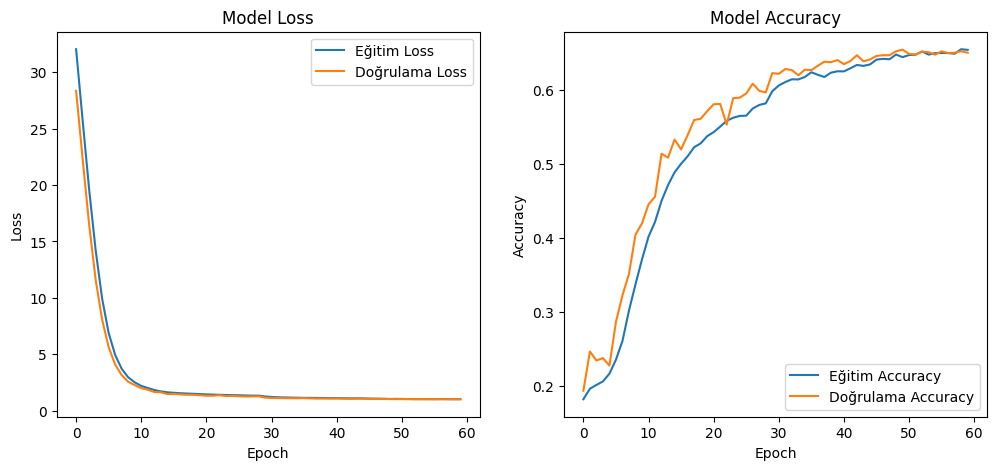

In [21]:
# 1️⃣ Eğitim ve doğruluk grafikleri
plt.figure(figsize=(12, 5))

# Kayıp
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Loss')
plt.plot(history.history['val_loss'], label='Doğrulama Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Doğruluk
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Accuracy')
plt.plot(history.history['val_accuracy'], label='Doğrulama Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**KARMAŞIKLIK MATRİSİ**

Karmaşıklık matrisi, sınıflandırma problemlerinde modelin performansını ayrıntılı biçimde değerlendirmeye yarayan bir tablodur. Satırlarda gerçek sınıflar, sütunlarda ise modelin tahmin ettiği sınıflar yer alır. Böylece hangi sınıfların doğru tahmin edildiği, hangilerinin diğer sınıflarla karıştırıldığı açıkça görülebilir. Özellikle çok sınıflı yüz ifadeleri tanıma gibi projelerde, yalnızca genel doğruluk oranına bakmak yetersiz kalabilir; karmaşıklık matrisi sayesinde modelin hangi ifadeleri daha iyi öğrendiği, hangi ifadelerde zorlandığı anlaşılır ve bu bilgi modelin geliştirilmesi için yönlendirici olur.

Bu bölümde modelin test verisi üzerindeki performansı ölçülmektedir. Öncelikle test setinden tahmin olasılıkları alınır ve en yüksek olasılığa sahip sınıf tahmini yapılır. Daha sonra **classification report** ile her sınıfa ait precision, recall ve F1-score değerleri elde edilir. **Confusion matrix** görselleştirilerek modelin hangi sınıflarda doğru veya yanlış tahmin yaptığı incelenir. 

Ayrıca çok sınıflı senaryoda **ROC AUC skoru** hesaplanarak modelin ayrım gücü değerlendirilir ve son olarak makro F1 skoru ile sınıflar arası dengeli performans ölçümü yapılır. Bu analizler modelin sadece doğruluk oranı değil, aynı zamanda sınıf bazlı başarı ve genelleme yeteneğini de ortaya koyar.

221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.64      0.60       958
           1       0.58      0.33      0.42      1024
           2       0.88      0.86      0.87      1774
           3       0.55      0.74      0.63      1233
           4       0.56      0.49      0.52      1247
           5       0.74      0.80      0.77       831

    accuracy                           0.66      7067
   macro avg       0.64      0.64      0.63      7067
weighted avg       0.66      0.66      0.65      7067



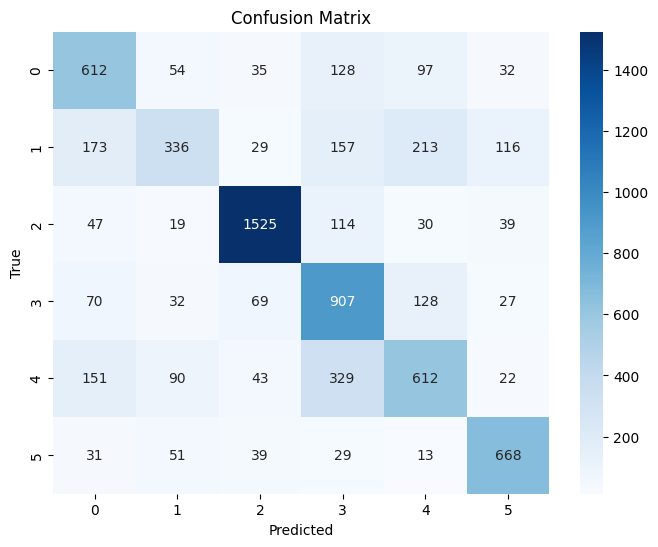

ROC AUC Score (macro): 0.9060
F1 Score (macro): 0.6342


In [22]:
steps = test_generator.samples // test_generator.batch_size
if test_generator.samples % test_generator.batch_size != 0:
    steps += 1

y_pred_probs = model.predict(test_generator, steps=steps, verbose=1)

y_true = test_generator.classes

y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

try:
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=np.arange(test_generator.num_classes))
    roc_auc = roc_auc_score(y_true_bin, y_pred_probs, multi_class='ovr')
    print(f"ROC AUC Score (macro): {roc_auc:.4f}")
except Exception as e:
    print(f"ROC AUC calculation failed: {e}")

f1 = f1_score(y_true, y_pred_classes, average='macro')
print(f"F1 Score (macro): {f1:.4f}")

**ROC ANALİZİ**

ROC analizi, modelin her sınıf için pozitif–negatif ayrımını ne kadar doğru yaptığını görmemizi sağlar. Çok sınıflı bir veri seti kullanıldığı için, ROC eğrileri her bir sınıf için ayrı ayrı çizilmiş, ayrıca micro ve macro ortalama AUC değerleri hesaplanarak modelin genel başarısı sunulmuştur.

Micro AUC, tüm sınıflar için tahminlerin tek bir bütün halinde değerlendirilmesiyle elde edilen başarıyı gösterir.

Macro AUC, her sınıfın AUC değerlerinin ortalamasıdır ve tüm sınıfları eşit önemde kabul eder.

Bu analiz, hem eğitim hem de test veri setleri üzerinde gerçekleştirilmiş ve sonuçlar yüzde cinsinden başarı oranlarıyla raporlanmıştır. ROC eğrileri ve AUC değerleri sayesinde modelin sınıf bazlı ayrım gücü detaylı şekilde görülmüş, yalnızca doğruluk oranına bakmak yerine modelin hangi sınıflarda daha güçlü veya zayıf olduğu daha açık bir biçimde değerlendirilmiştir.

733/733 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


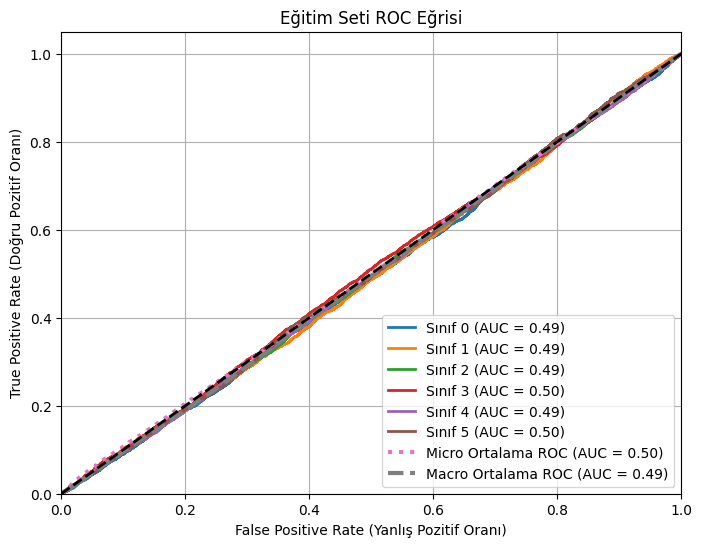

Eğitim Seti Ortalama Başarı (Macro AUC): 49.45%


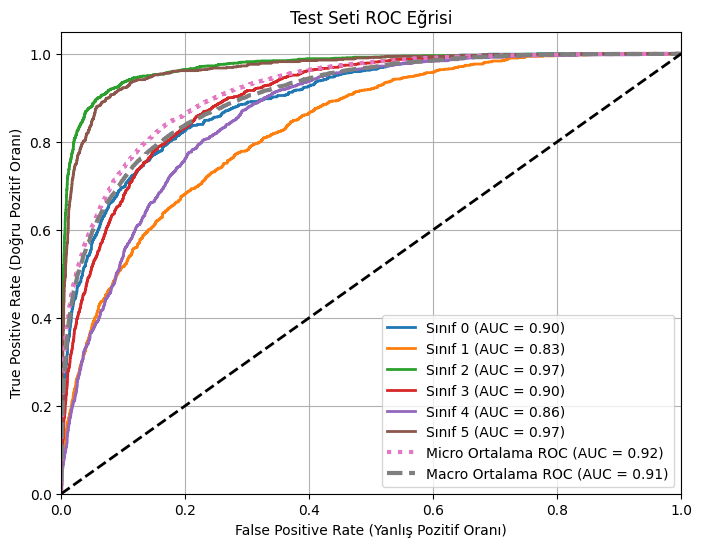

Test Seti Ortalama Başarı (Macro AUC): 90.60%


In [24]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# ======================
# 1. Tahminler ve Gerçek Değerler
# ======================

# Eğitim seti için tahmin
y_train_true = train_gen.classes
y_train_prob = model.predict(train_gen, verbose=1)
y_train_true_bin = label_binarize(y_train_true, classes=list(range(num_classes)))

# Test seti için tahmin
y_test_true = test_generator.classes
y_test_prob = model.predict(test_generator, verbose=1)
y_test_true_bin = label_binarize(y_test_true, classes=list(range(num_classes)))

# ======================
# 2. ROC Eğrisi Çizimi (Multi-Class)
# ======================
def plot_multiclass_roc(y_true_bin, y_prob, title="ROC Eğrisi"):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Ortalama ROC (Micro ve Macro)
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    # Çizim
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f"Sınıf {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot(fpr["micro"], tpr["micro"], linestyle=":", linewidth=3,
             label=f"Micro Ortalama ROC (AUC = {roc_auc['micro']:.2f})")
    plt.plot(all_fpr, mean_tpr, linestyle="--", linewidth=3,
             label=f"Macro Ortalama ROC (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (Yanlış Pozitif Oranı)")
    plt.ylabel("True Positive Rate (Doğru Pozitif Oranı)")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return roc_auc

# ======================
# 3. Eğitim Seti ROC Analizi
# ======================
roc_auc_train = plot_multiclass_roc(y_train_true_bin, y_train_prob, title="Eğitim Seti ROC Eğrisi")
print(f"Eğitim Seti Ortalama Başarı (Macro AUC): {roc_auc_train['macro']*100:.2f}%")

# ======================
# 4. Test Seti ROC Analizi
# ======================
roc_auc_test = plot_multiclass_roc(y_test_true_bin, y_test_prob, title="Test Seti ROC Eğrisi")
print(f"Test Seti Ortalama Başarı (Macro AUC): {roc_auc_test['macro']*100:.2f}%")


**MODEL TAHMİN ETME**

Test verisi üzerinden yapılan tahminde, önce doğru ve yanlış sınıflandırılan örneklerin indeksleri belirlenmiş, ardından ilk dört doğru ve ilk dört yanlış tahmin görselleştirilmiştir. Görsellerde her bir yüz ifadesinin **gerçek sınıf etiketi** ve **modelin tahmini** birlikte gösterilerek modelin güçlü ve zayıf olduğu noktalar gözlemlenebilir. Bu yöntem, modelin hatalarını daha somut bir şekilde analiz etmeye ve geliştirme için yön belirlemeye yardımcı olur.

Bu yöntem, modelin başarısını yalnızca sayısal metriklerle (accuracy, loss, f1-score gibi) değil, görsel ve niteliksel olarak da değerlendirebilmek için kullanılmıştır. Çünkü yüz ifadeleri gibi görsel tabanlı verilerde, modelin hangi örneklerde doğru tahmin yaptığı ve hangi örneklerde zorlandığı çok önemlidir


221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


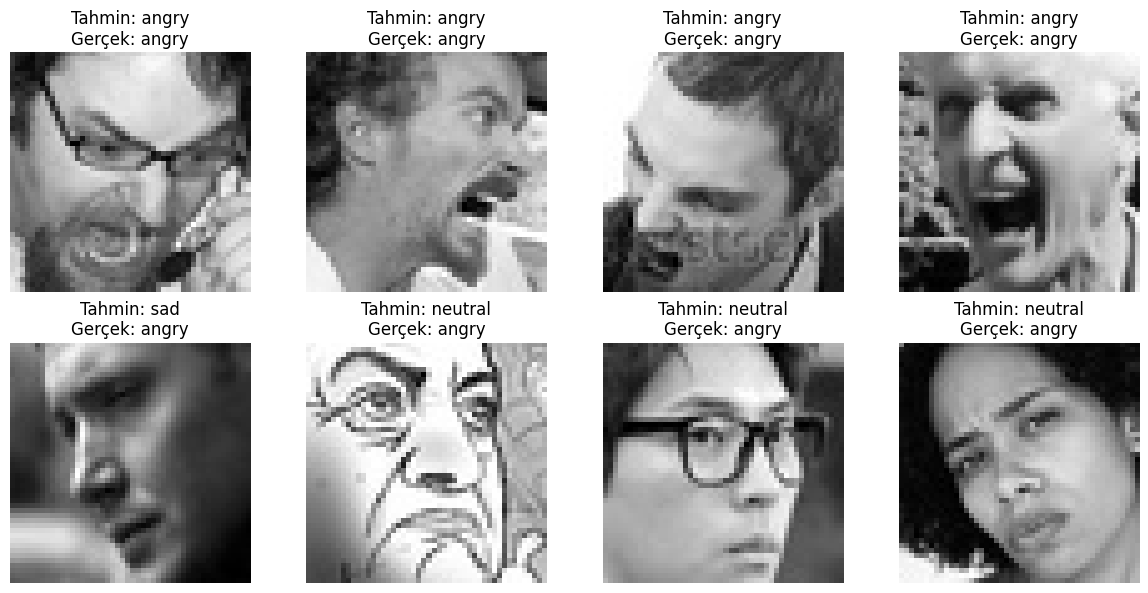

In [23]:
# Test verisi üzerinden tahmin
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Doğru ve yanlış tahminlerin indeksleri
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

# Görselleştirme
plt.figure(figsize=(12, 6))

# Doğru tahmin örnekleri (ilk 4)
for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2, 4, i+1)
    batch_index = correct // test_generator.batch_size
    within_batch_index = correct % test_generator.batch_size
    batch = test_generator[batch_index][0]
    img = batch[within_batch_index]
    
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Tahmin: {class_names[y_pred_classes[correct]]}\nGerçek: {class_names[y_true[correct]]}")
    plt.axis('off')

# Yanlış tahmin örnekleri (ilk 4)
for i, incorrect in enumerate(incorrect_indices[:4]):
    plt.subplot(2, 4, i+5)
    batch_index = incorrect // test_generator.batch_size
    within_batch_index = incorrect % test_generator.batch_size
    batch = test_generator[batch_index][0]
    img = batch[within_batch_index]
    
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Tahmin: {class_names[y_pred_classes[incorrect]]}\nGerçek: {class_names[y_true[incorrect]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
